# Quantum Crytography

In [3]:
# Create a 2-qubit quantum circuit
n_qubits = 2
circuit = QuantumCircuit(n_qubits, n_qubits)

# Apply Hadamard gates to create superposition of states
for i in range(n_qubits):
    circuit.h(i)

# Prepare the classical register
circuit.measure_all()

# Execute the circuit on a quantum simulator
simulator = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(circuit, simulator)
job = execute(transpiled_circuit, simulator, shots=1000)
result = job.result()

# Print the results
counts = result.get_counts()
print("Counts:", counts)

# Remove the space in the keys and convert the binary states to integers
exponents = [int(k.replace(" ", ""), 2) for k in counts.keys()]
powers_of_seven = [7 ** e for e in exponents]
print("Powers of 7:", powers_of_seven)


Counts: {'01 00': 240, '11 00': 262, '10 00': 268, '00 00': 230}
Powers of 7: [2401, 13841287201, 5764801, 1]


In [4]:
7**2

49

In [5]:
49**2

2401

In [6]:
2401**2

5764801

In [4]:
import math
import qiskit
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint

In [5]:
# Define the controlled-U gate for a^power mod N
def c_amodN(a, power, N):
    if power < 0:
        raise ValueError("'power' must be non-negative")
    n_aux = math.ceil(math.log2(N))  # Number of auxiliary qubits
    U = QuantumCircuit(n_aux)  # Create a quantum circuit with n_aux qubits
    for _ in range(power):
        U.swap(n_aux - 1, n_aux - 2)  # Swap the last two qubits
        U.swap(n_aux - 2, n_aux - 3)  # Swap the second and third qubits from the end
        # Add controlled-phase gates for each qubit
        for q in range(n_aux - 1):
            U.append(qiskit.circuit.library.CPhaseGate(a**(2**q) % N), [q, n_aux - 1])
    U = U.to_gate()  # Convert the quantum circuit to a gate
    U.name = f"C-U({a}^{power} mod {N})"
    return U

This function defines a controlled-U gate for a^power mod N in a quantum circuit. The controlled-U gate represents the modular exponentiation operation used in quantum phase estimation for Shor's algorithm.

Here's a breakdown of the code:

It checks if the power is non-negative, raising a ValueError if it is negative.
It calculates the number of auxiliary qubits needed (n_aux) based on the value of N.
It creates a quantum circuit U with n_aux qubits.

The function then performs the following operations power times:

a. It swaps the last two qubits in the circuit.

b. It swaps the second and third qubits from the end.

c. For each qubit (except the last one), it adds a controlled-phase gate (CPhaseGate) with an angle corresponding to a^(2^q) % N, where 'a' is the base and 'q' is the qubit index.

The quantum circuit U is converted to a gate, and a descriptive name is assigned to the gate.
The function returns the created controlled-U gate.

The controlled-U gate created by this function is used in the quantum phase estimation circuit, which helps determine the period of the modular exponentiation function a^x mod N, a crucial step in Shor's algorithm for factoring large numbers.

In [7]:
# Define the quantum phase estimation circuit with the controlled-U gate
def qpe_amodN(a, N, n_count):
    n_aux = math.ceil(math.log2(N))  # Number of auxiliary qubits
    qc = QuantumCircuit(n_count + n_aux, n_count)  # Create a quantum circuit with n_count + n_aux qubits and n_count classical bits
    for q in range(n_count):
        qc.h(q)  # Apply a Hadamard gate on each counting qubit
    qc.x(n_count + n_aux - 1)  # Apply an X gate on the last auxiliary qubit

    # Add the controlled-U gates for each counting qubit
    for q in range(n_count):
        qc.append(c_amodN(a, 2 ** q, N), [q] + list(range(n_count, n_count + n_aux - 1)))

    # Apply the inverse quantum Fourier transform on the counting qubits
    qc.append(qiskit.circuit.library.QFT(n_count, do_swaps=False).inverse(),
              range(n_count))
    qc.measure(range(n_count), range(n_count))  # Measure the counting qubits
    return qc

In [8]:
# Run the quantum phase estimation circuit and get the results
def run_qpe_amodN(a, N, n_count):
    # Create a quantum phase estimation circuit for 'a' modulo 'N' using 'n_count' qubits
    qc = qpe_amodN(a, N, n_count)
    
    # Get the Aer backend 'aer_simulator' for running the quantum circuit
    aer_sim = Aer.get_backend('aer_simulator')
    
    # Transpile the quantum circuit 'qc' for the 'aer_simulator' backend
    t_qc = transpile(qc, aer_sim)
    
    # Assemble the transpiled quantum circuit 't_qc' into a Qobj with 1000 shots
    qobj = qiskit.assemble(t_qc, shots=1000)
    
    # Run the assembled 'qobj' on the 'aer_simulator' backend and get the result
    results = aer_sim.run(qobj).result()
    
    # Get the counts (measurement outcomes) from the 'results' object
    counts = results.get_counts()
    
    # Return the counts of the circuit execution
    return counts

This function, run_qpe_amodN, takes three input parameters: a, N, and n_count. It creates a quantum phase estimation circuit for 'a' modulo 'N' using 'n_count' qubits, transpiles and assembles the circuit, runs it on the Aer simulator backend with 1000 shots, and returns the counts (measurement outcomes) of the circuit execution.

In [9]:
# Convert the results from the phase estimation into an integer
def get_amodN_result(a, N, n_count):
    # Run the quantum phase estimation circuit and get the counts
    counts = run_qpe_amodN(a, N, n_count)
    
    # Find the phase with the maximum count (highest probability)
    phase = max(counts, key=counts.get)
    
    # Convert the phase to a binary string with leading zeros and length 'n_count'
    phase_as_bin = list(format(int(phase), f'0{n_count}b'))

    # Initialize the variable 'k' for storing the converted result
    k = 0
    
    # Iterate through the binary string and convert it to an integer
    for i in range(n_count):
        k = k + int(phase_as_bin.pop(0)) * (2 ** (n_count - i - 1))
    
    # Return the converted integer value 'k'
    return k

This function, get_amodN_result, takes three input parameters: a, N, and n_count. It runs the quantum phase estimation circuit using the run_qpe_amodN function and gets the counts. Then, it finds the phase with the maximum count (highest probability) and converts the phase to a binary string with leading zeros and length n_count. The function iterates through the binary string and converts it to an integer. Finally, it returns the converted integer value 'k'.

In [3]:
# Factorize the number N using Shor's algorithm
def factorize(N):
    n_count = math.ceil(math.log2(N))
    n_trials = 10  # Number of trials to find a non-trivial factor (((2 is the minimum with error eventually))) 
    for _ in range(n_trials):
        a = randint(2, N)  # Randomly choose an integer a between 2 and N-1
        factor = gcd(a, N)  # Find the greatest common divisor of a and N

        # If the greatest common divisor is not 1 or N, we have found a non-trivial factor
        if factor != 1 and factor != N:
            return factor, N // factor

        # Run quantum phase estimation and get the result as an integer
        r = get_amodN_result(a, N, n_count)

        # If the result is odd, continue with the next trial
        if r % 2 != 0:
            continue

        # Calculate the factors using the result of quantum phase estimation
        x = a ** (r // 2) % N
        y = (x + 1) % N
        factor1 = gcd(x - 1, N)
        factor2 = gcd(y, N)

        # If we find non-trivial factors, return them
        if factor1 != 1 and factor1 != N:
            return factor1, N // factor1
        if factor2 != 1 and factor2 != N:
            return factor2, N // factor2

    # If we don't find any factors after n_trials trials, return a message indicating failure
    return "Failed to find factors"

N = 77
factors = factorize(N)
print("Factors of", N, "are", factors)



Factors of 77 are (7, 11)


The final section of the code is the main function factorize(N) that combines all the previously defined functions to run Shor's algorithm and find the factors of the given number N. The algorithm is tried for n_trials times, and if a non-trivial factor is found, it is returned. If no factors are found after all trials, a message indicating failure is returned.

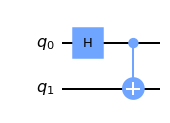

In [1]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

# Create a simple quantum circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

# Draw the circuit using the draw() method
qc.draw(output='mpl')

# Alternatively, draw the circuit using the circuit_drawer() function
circuit_drawer(qc, output='mpl')
